# Predictive Power of FOMC statements on VIX



# Introduction

In this notebook, we have the following goal: find alpha in statements of FOMC meetings in relation to the VIX index. This will be achieved by using both algorithms seen in class and literature on the subject.

The VIX is intended to act as a forward-looking indicator of expected short term volatility (Whaley, 2009)and is also called the fear-index. Furthermore, using the VIX index is often preferred as it eliminates known measurement errors associated with measuring implied volatility (Blair, Poon, and Taylor ,2001). As a result, the behavior of the VIX can be understood as a possible reflection of market uncertainty.

We thus expect the release of major economic statemtents to reduce the VIX index on average, as market participants would be more aware of the thinking of major policy makers.This has been documented by Ederington and Lee (1996). We can however differanciate between expected and unexpected statements, as they induce contrasting effect on VIX levels. Bernanke and Kuttner (2003) document the effect of the unanticipated Federal Reserve policy
decisions on equity prices and provide reasoning for the stock market's response. The results are split into expected and surprise policy actions to provide a relative perspective of the possible impact. In order to estimate a surprise action, the authors follow the research of Kuttner (2001) by analyzing Fed funds futures data. The results indicate that the surprise rate changes have a significant impact on markets.

We shall not take an interest in the seasonnal properties of the VIX index apart from the FOMC statements(VIX tends to be higher on Mondays, Gonzalez-Perez and Guerrero (2013)), even though a complete trading strategy might look to take into account every aspect at hand.

The focus of our work is to develop a strategy on the VIX using FOMC meetings, whether it be using NLP of the statements or studying the actual decisions of the meetings.

# Package Import

Firstly, we look to import the skfin package, which will be useful for all sort of things, as well as the other libraries.

In [1]:
!git clone https://github.com/schampon/skfin.git
%cd skfin
!./create_env.sh

fatal: destination path 'skfin' already exists and is not an empty directory.
/content/skfin
./create_env.sh: line 1: conda: command not found
./create_env.sh: line 2: conda: command not found
Obtaining file:///content/skfin
  Preparing metadata (setup.py) ... done
  Attempting uninstall: skfin
    Found existing installation: skfin 0.0.0
    Uninstalling skfin-0.0.0:
      Successfully uninstalled skfin-0.0.0
  Running setup.py develop for skfin
Installed kernelspec skfin in /root/.local/share/jupyter/kernels/skfin


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from datetime import date
from pathlib import Path

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from skfin.plot import bar, line
from tqdm.auto import tqdm
import yfinance as yf
from collections import Counter
from sklearn.linear_model import LogisticRegression
from skfin.datasets import load_fomc_change_date
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from skfin.datasets import load_fomc_statements, load_loughran_mcdonald_dictionary
from skfin.plot import line
from skfin.text import coefs_plot, show_text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from pandas.tseries.offsets import BDay
from skfin.datasets import load_kf_returns
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.pipeline import Pipeline

from skfin.datasets import load_fomc_change_date
import matplotlib.cm as cm
from sklearn.decomposition import NMF, PCA

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.svm import SVR


from functools import reduce
import seaborn as sns

# Data Overview

For this project, we elect to use the Loughran-Mcdonald dictionary (McDonald, Loughran, 2011)in a first instance to measure the overall sentiment of FOMC statements. Furthermore, we obtain the actual statements from the datasets comprised in skfin. Finally, the VIX index close values are retrieved from Yahoo Finance through the yfinance module.

In [3]:
statements = load_fomc_statements()
lm = load_loughran_mcdonald_dictionary()


As mentionned in the introduction, the literature cites a significantly different impact of unannonced FOMC meeting compared to expected ones. By its very nature, the VIX index is heavely dependant on various market conditions and thus our study of the impact of FOMC meetings would benefit greatly from excluding unscheduled meetings from our dataset as these mostly appear in extraordinary circumstances. These could potentially hold a lot of alpha in terms of vocabulary used as but we choose to stay clear from such strategies for the moment.

In [4]:
Counter([x.year for x in statements.index])

Counter({1999: 6,
         2000: 8,
         2001: 11,
         2002: 8,
         2003: 8,
         2004: 8,
         2005: 8,
         2006: 8,
         2007: 10,
         2008: 11,
         2009: 8,
         2010: 9,
         2011: 8,
         2012: 8,
         2013: 8,
         2014: 8,
         2015: 8,
         2016: 8,
         2017: 8,
         2018: 8,
         2019: 9,
         2020: 12,
         2021: 8,
         2022: 8,
         2023: 8,
         2024: 1})

There should be 8 meetings per year. However, without that much historical context, it is not easy to choose which FOMC meeting dates should not be considered. We only consider the following dates to be excluded, a choice akin to the one in the lectures.

In [5]:
# Removing special days
print(len(statements.index))
special_days = ["2008-01-22", "2010-05-09", "2020-03-15"]
idx0 = pd.to_datetime(pd.Index(special_days))
idx = statements.index.difference(idx0)
statements = statements.loc[idx]
print(len(statements.index))

213
210


As for our target feature, we use VIX index data from yfinance. We pull data dating back to 1999 as that is the starting point for the statement database. There were changes made in the VIX computation methodology since its inception (1993), but these can be considered negligible over our window of study (Grieb, Krichel, Vaisanen, 2016).

In [6]:
vix_ticker = "^VIX"

start_date = "1999-01-01"
end_date = "2024-02-01"

vix_data = yf.download(vix_ticker, start=start_date, end=end_date)

vix_returns=pd.DataFrame(vix_data['Close'].pct_change()[1:])

[*********************100%***********************]  1 of 1 completed


#Initial analysis of the problem

Simple overview of the VIX index & FOMC statements

/tmp/ipykernel_121901/191147317.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o:r" (-> marker='o'). The keyword argument will take precedence.
  axs[2].plot(vix_data["Close"].loc[idx_end.strftime('%Y-%m-%d')], 'o:r', marker="*", ms=5)


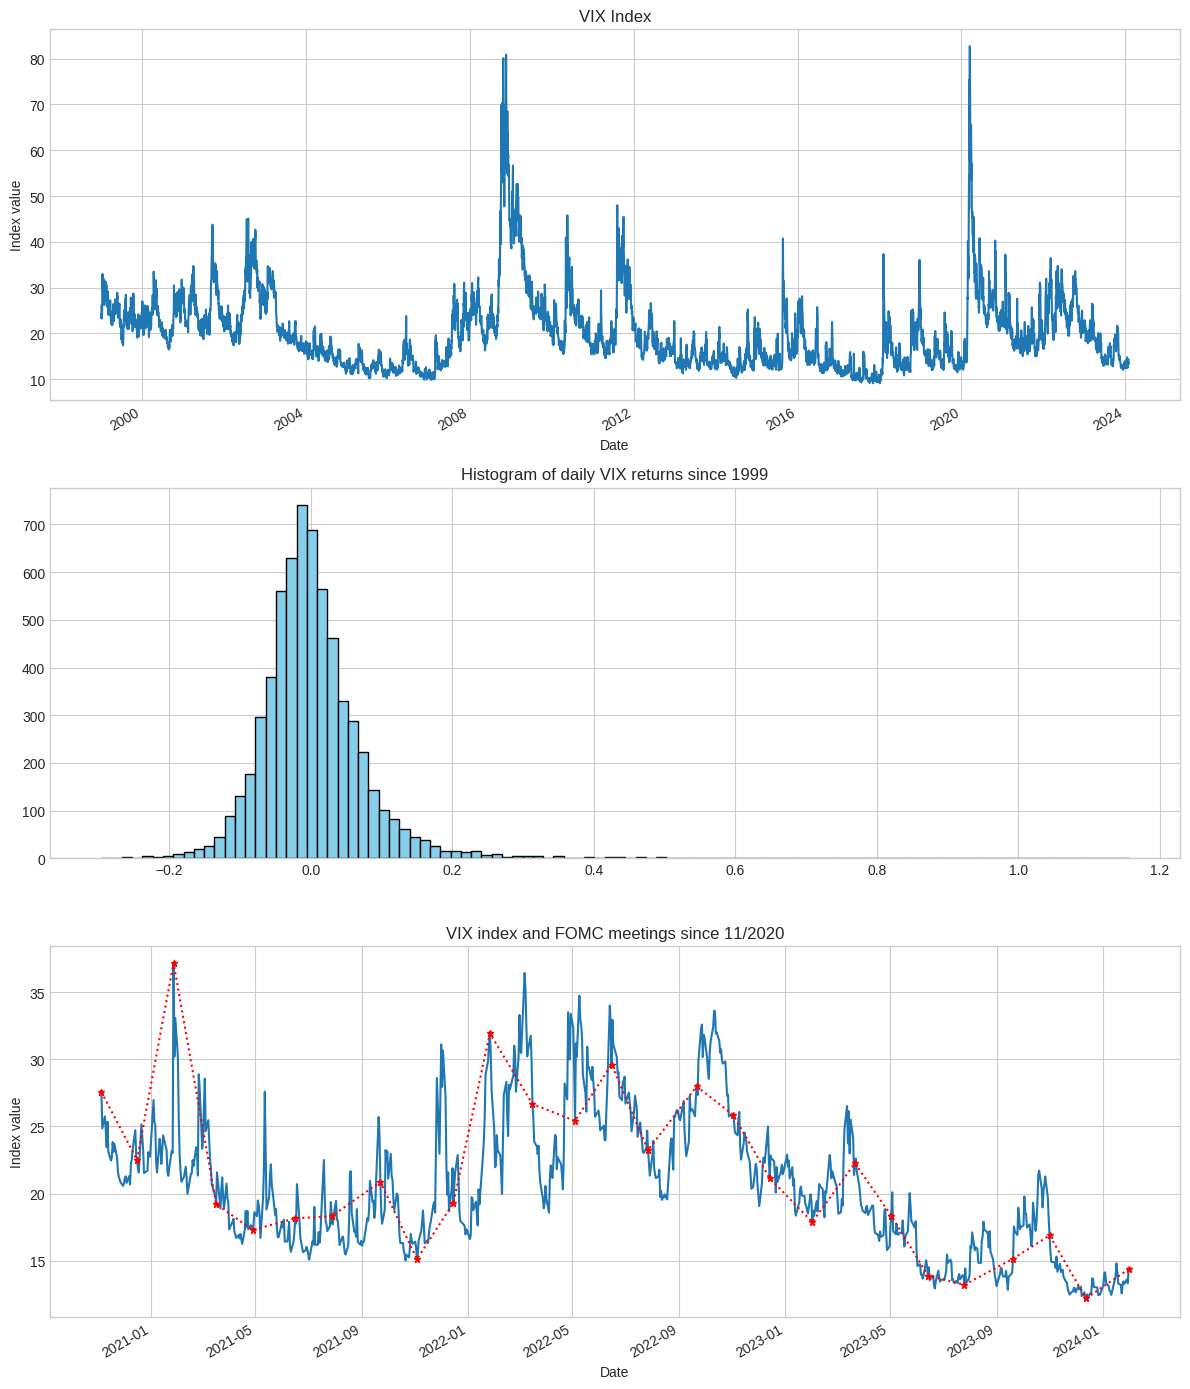

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(12, 14))

vix_data["Close"].plot(title="VIX Index", ylabel="Index value", xlabel="Date", ax=axs[0])

axs[1].hist(np.clip(vix_returns['Close'], -5, 5), color='skyblue', bins = 100, edgecolor='black')
axs[1].set_title('Histogram of daily VIX returns since 1999')

vix_data["Close"][5497:].plot(title="VIX Index", ylabel="Index value", xlabel="Date", ax=axs[2])
idx_end = idx[183:]
axs[2].plot(vix_data["Close"].loc[idx_end.strftime('%Y-%m-%d')], 'o:r', marker="*", ms=5)
axs[2].set_title('VIX index and FOMC meetings since 11/2020')

plt.tight_layout()
plt.show()

Whaley (2008) explains that the VIX historically follows mean-reverting tendencies, which is not disproved by the overall flat forward of the index, and the profil of its returns : slightly skewed negatively but with a fatter tail on the positive side. Last graph shows the evolution of the VIX for the past 3 years, as well as the occurence of the FOMC meetings in that time span. These meetings appear to occasionally be local extrema, but there is no consistent trend on that front.

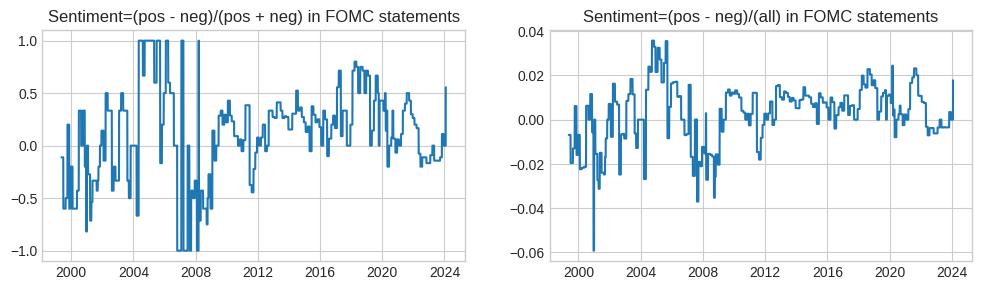

In [8]:
# First analysis
# Find the negative and positive words in the statements

X = statements["text"]

funcs = {
    "negative": lambda x: x.Negative > 0,
    "positive": lambda x: x.Positive > 0,
    "all": lambda x: x.Word.notna(),
}

def get_total_count(X, lm, func):
    m = CountVectorizer(vocabulary=lm.loc[func].Word.str.lower().values)
    return pd.DataFrame(m.fit_transform(X).toarray(), index=X.index).sum(axis=1)

lm_counts = pd.concat({k: get_total_count(X, lm, v) for k, v in funcs.items()}, axis=1)

# This cell will show the negative (red) and positive (green) words in each statement
# and will plot the evolution of the sentiment in the FOMC statements throughout the years

fig, axs = plt.subplots(1, 2, figsize=(12, 3))

line(
    lm_counts.pipe(lambda x: (x.positive - x.negative) / (x.positive + x.negative))
    .resample("B")
    .last()
    .ffill(),
    legend=False,
    title="Sentiment=(pos - neg)/(pos + neg) in FOMC statements",
    ax=axs[0]
)

line(
    lm_counts.pipe(lambda x: (x.positive - x.negative) / x["all"])
    .resample("B")
    .last()
    .ffill(),
    legend=False,
    title="Sentiment=(pos - neg)/(all) in FOMC statements",
    ax=axs[1]
)

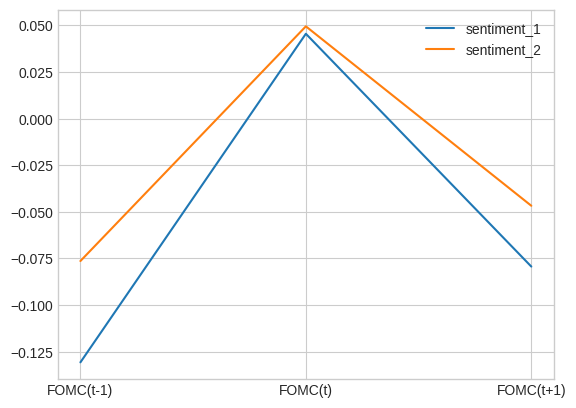

In [9]:
range_ = 1
sent1 = lm_counts.pipe(lambda x: (x.positive - x.negative) / x["all"])
sent2 = lm_counts.pipe(lambda x: (x.positive - x.negative) / (x.positive + x.negative))
correl1 = []
correl2 = []

lags = [i for i in range(-range_, range_+1)]
for lag in lags:
  correl1.append((vix_returns['Close'].shift(-lag)).corr(sent1))
  correl2.append((vix_returns['Close'].shift(-lag)).corr(sent2))

correl_vix_lag = pd.DataFrame({'sentiment_1': correl1, 'sentiment_2': correl2})
correl_vix_lag.index = lags

ax = correl_vix_lag.plot()

# Customize x-axis tick positions and labels
ax.set_xticks([-1, 0, 1])
ax.set_xticklabels(["FOMC(t-1)", "FOMC(t)", "FOMC(t+1)"])

plt.show()

We here plot correlation of these 2 sentiment series with VIX returns on days of FOMC meetings with a lag (FOMC(t+1) represents the day after a meeting...). Here, correlation for the day before for both sentiment computation methodologies seems consequential: VIX appears to be worthy of its title of 'index of fear'.

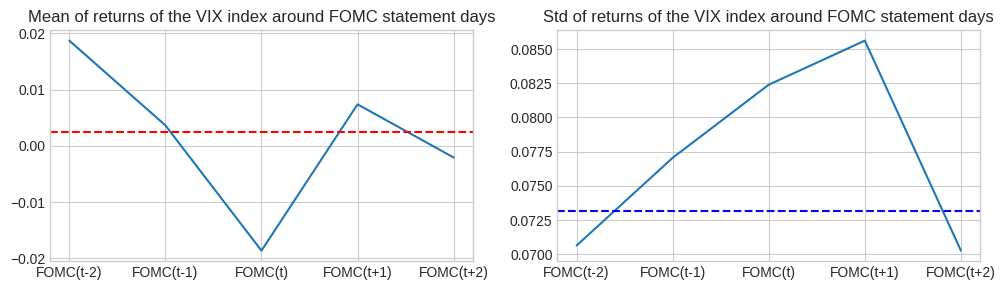

In [10]:
range_ = 2
lags = [i for i in range(-range_, range_+1)]
means = []
stds = []
for lag in lags:
  laged_index = statements.index + pd.tseries.offsets.BDay(lag)
  vix_laged = vix_returns.loc[laged_index.intersection(vix_returns.index)]
  mean = vix_laged.mean()['Close']
  std = vix_laged.std()['Close']
  stds.append(std)
  means.append(mean)


stats_vix_lag = pd.DataFrame({'means': means, 'stds': stds})
stats_vix_lag.index = lags

fig, axs = plt.subplots(1, 2, figsize=(12, 3))

stats_vix_lag['means'].plot(ax=axs[0])
axs[0].axhline(y=vix_returns.mean()['Close'], color='r', linestyle='--',
               label=f'Horizontal Line at {np.round(vix_returns.mean()["Close"], 5)}')
axs[0].set_xticks(lags)
axs[0].set_xticklabels(["FOMC(t-2)", "FOMC(t-1)", "FOMC(t)", "FOMC(t+1)", "FOMC(t+2)"])
axs[0].set_title('Mean of returns of the VIX index around FOMC statement days')

stats_vix_lag['stds'].plot(ax=axs[1])
axs[1].axhline(y=vix_returns.std()['Close'], color='b', linestyle='--',
               label=f'Horizontal Line at {np.round(vix_returns.std()["Close"], 5)}')
axs[1].set_xticks(lags)
axs[1].set_xticklabels(["FOMC(t-2)", "FOMC(t-1)", "FOMC(t)", "FOMC(t+1)", "FOMC(t+2)"])
axs[1].set_title('Std of returns of the VIX index around FOMC statement days')

plt.show()

In the figure above, on the leftmost graph, we can see that VIX returns are indeed negative on FOMC meeting days, significantly lower than the average return across the whole period (represented by the red-dotted line). This validates what was supposed in the introduction: by representing the VIX as the index of uncertainty, on average, a FOMC decision concerning Fed Fund rates brings clarity to investors about the upcoming market, thus bringing the VIX down. It also confirms the U-shape around statements as the returns are on average higher than the mean both before and after the meeting.

From the second graph, we can gather that VIX is itself more volatile around FOMC dates, as the standard deviations of the returns are more important around and at FOMC meeting dates (the standard deviation of the whole series is represented by the blue-dotted line).

This is very important for our strategy: firstly, this indicates that there could be non-negligible alpha in our study; secondly, this std is at its highest for t+1 returns. Market participants usually react almost instantly to the statements (usually a 30-minute window after the announcement). Intraday data of this sort isn't available to us at this time, only index close quotes.

Furthermore, if we were to put such a strategy into place, positions taken on the basis of FOMC statement analysis could only be made after the statements. As such, we really are interested in t+1 returns after analysis of FOMC statement at date t. This means that, even though we can't take part in the immediate movement of VIX following the statements, we can still appreciate some mean-reversion the following day.

Finally, now that we know that there are more ups than downs on FOMC(t+1) days, we expect a succeful strategy to likely feature this property.

# Implementing our strategy

The baseline strategy is very similar to the one seen in the lectures (chapter 19). After normalizing the returns series, we will try supervised learning by using pipelines comprised of the Tfidfectorizer method and some machine learning algorithms (a few are used here).

The TFIDF score enables us to record impactful words of each statements in the context of the entire corpus of statements. We then use the ML algorithm to match the text of each statement to VIX returns. As expressed earlier, the returns on the actual day of the meetings are not the most relevant as they would not be tradable, so we will shift our focus on the returns days after the actual statements: t+1, t+2, t+3... (which should still be relevant if we believe the previous figure).

In this section, we try 2 sorts of strategies: one where we simply predict the sign of the returns (if above 0.05 in absolute value to avoid noise). Thus, our Pnl series is simply : sign_predicted * r_real_(t+1). From there, we can calculate a Sharpe ratio.

The other type of strategy is rather to try to predict the return of the VIX index directly, not just the sign. For this strategy, how much to invest on a given day can be done a multitude of ways. Maybe naively, we choose to invest proportionally to what we predict, as to be very long if we predict big returns and very short in the opposed scenario. The Pnl series becomes: r_predicted_(t+1) * r_real_(t+1).

The following code enacts these strategies (model_binary, model_continuous) for multiple ML algorithms (ElasticNet, RandomForest, Gradient Boosting Regressor, Support Vector Regression, Gradient Boosting Classifier), simply to compare different methods, as well as for returns shifted for different horizons.

Every time, we will split 80% of our dataset into a train set and the rest in a test set in order to compute a Sharpe ratio. We will come back on this later.

In [11]:

def compute_lagged_return(vix_data,lag):
  """

  gives the lagged returns of the VIX in output.
  For instance, if lag = 1 then, it will give in output the returns of the next day after each statement release
  """
  vix_returns=pd.DataFrame(vix_data['Close'].pct_change()[1:]).shift(-lag)
  special_days = ["2008-01-22", "2010-05-09", "2020-03-15"]
  idx0 = pd.to_datetime(pd.Index(special_days))
  idx = statements.index.difference(idx0)#.union(idx0 + BDay(1))
  ret_fomc = vix_returns.div(vix_returns.ewm(252).std()).loc[vix_returns.index.intersection(idx)]
  return ret_fomc

def run_model_continuous(statements,returns,model):
  """

  Predicts the returns with distinct NLP/ML models.

  """
  if model=='ElasticNet':
    est = Pipeline([
        ("tfidf", TfidfVectorizer(
            vocabulary=None,
            ngram_range=(1, 3),
            max_features=300,
            stop_words="english",
            token_pattern=r"\b[a-zA-Z]{3,}\b",
        )),
        ("reg",  ElasticNet(alpha=0.008))
    ])

  elif model=='RF':
    est = Pipeline([
        ("tfidf", TfidfVectorizer(
            vocabulary=None,
            ngram_range=(1, 3),
            max_features=300,
            stop_words="english",
            token_pattern=r"\b[a-zA-Z]{3,}\b",
        )),
        ("reg", RandomForestRegressor(n_estimators=100, random_state=42))
    ])

  elif model=='GBR':
    est = Pipeline([
        ("tfidf", TfidfVectorizer(
            vocabulary=None,
            ngram_range=(1, 3),
            max_features=300,
            stop_words="english",
            token_pattern=r"\b[a-zA-Z]{3,}\b",
        )),
        ("reg", GradientBoostingRegressor(n_estimators=100, random_state=42))
    ])

  elif model=='SVR':
    est = Pipeline([
        ("tfidf", TfidfVectorizer(
            vocabulary=None,
            ngram_range=(1, 3),
            max_features=300,
            stop_words="english",
            token_pattern=r"\b[a-zA-Z]{3,}\b",
        )),
        ("reg", SVR())
    ])

  #returns=returns[(returns['Close'] < -0.05) | (returns['Close'] > 0.05)]
  y=returns["Close"].dropna()
  y_index=y.index
  statements_concerned=statements.loc[statements.index.isin(y_index)]

  X=statements_concerned['text']
  y=y.loc[X.index]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

  est.fit(X_train, y_train)
  y_pred = est.predict(X_test)

  results=pd.DataFrame(y_test)
  results['pred']=y_pred

  return results


def run_model_binary(statements,returns,model):
  """

  Predicts the sign of the returns with distinct NLP/ML models.

  """
  if model=='ElasticNet':
    est = Pipeline([
        ("tfidf", TfidfVectorizer(
            vocabulary=None,
            ngram_range=(1, 3),
            max_features=300,
            stop_words="english",
            token_pattern=r"\b[a-zA-Z]{3,}\b",
        )),
        ("reg",  ElasticNet(alpha=0.008))
    ])

    # elif model=='LogReg':
    # est = Pipeline([
    #     ("tfidf", TfidfVectorizer(
    #         vocabulary=None,
    #         ngram_range=(1, 3),
    #         max_features=300,
    #         stop_words="english",
    #         token_pattern=r"\b[a-zA-Z]{3,}\b",
    #     )),
    #     ("reg", LogisticRegression(max_iter=5000))
    # ])

  elif model=='RF':
    est = Pipeline([
        ("tfidf", TfidfVectorizer(
            vocabulary=None,
            ngram_range=(1, 3),
            max_features=300,
            stop_words="english",
            token_pattern=r"\b[a-zA-Z]{3,}\b",
        )),
        ("reg", RandomForestRegressor(n_estimators=100, random_state=42))
    ])

  elif model=='GBR':
    est = Pipeline([
        ("tfidf", TfidfVectorizer(
            vocabulary=None,
            ngram_range=(1, 3),
            max_features=300,
            stop_words="english",
            token_pattern=r"\b[a-zA-Z]{3,}\b",
        )),
        ("reg", GradientBoostingRegressor(n_estimators=100, random_state=42))
    ])

  elif model=='SVR':
    est = Pipeline([
        ("tfidf", TfidfVectorizer(
            vocabulary=None,
            ngram_range=(1, 3),
            max_features=300,
            stop_words="english",
            token_pattern=r"\b[a-zA-Z]{3,}\b",
        )),
        ("reg", SVR())
    ])

  elif model=='GBC':
      est = Pipeline([
          ("tfidf", TfidfVectorizer(
              vocabulary=None,
              ngram_range=(1, 3),
              max_features=300,
              stop_words="english",
              token_pattern=r"\b[a-zA-Z]{3,}\b",
          )),
          ("reg", GradientBoostingClassifier())
      ])


  returns=returns[(returns['Close'] < -0.005) | (returns['Close'] > 0.005)]
  y=np.sign(returns["Close"].dropna())
  y_index=y.index
  statements_concerned=statements.loc[statements.index.isin(y_index)]


  X=statements_concerned['text']
  y=y.loc[X.index]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
  est.fit(X_train, y_train)
  y_pred = est.predict(X_test)

  results=pd.DataFrame(y_test)
  results['pred']=np.sign(y_pred).astype(int)

  return accuracy_score(results['Close'],results['pred']),results

def compute_strategy(results,vix_data,lag):
  """

  Computes the induced strategy and the induces sharpe

  """
  data=pd.merge(results,vix_data['Close'],left_index=True,right_index=True)
  if lag !=0:
    data=pd.merge(data,vix_data['Close'].shift(-lag),left_index=True,right_index=True)
  else:
    data=pd.merge(data,vix_data['Close'].shift(1),left_index=True,right_index=True)

  data.columns=['Sign at t+'f'{lag}','Pred Sign at t+'+f'{lag}','Price at t','Price at t+'+f'{lag}']
  data['return at date t+'+f'{lag}']=(data['Price at t+'+f'{lag}']-data['Price at t'])/data['Price at t']
  if lag == 0:
    data['return at date t+'+f'{lag}']=(data['Price at t']-data['Price at t+'+f'{lag}'])/data['Price at t+'+f'{lag}']

  data['P&L']=data['Pred Sign at t+'+f'{lag}']*data['return at date t+'+f'{lag}']

  df_sharpe=pd.DataFrame(index=results.index)#index=range(5000)
  df_sharpe['P&L']=data['P&L']
  df_sharpe['P&L']=df_sharpe['P&L'].fillna(0)
  sharpe=np.sqrt(8)*df_sharpe['P&L'].mean()/(df_sharpe['P&L'].std()*np.sqrt(2))
  return data,sharpe

def pnl_graph(data):
  return data['P&L'].cumsum().plot()

# Main empirical results

In this section, we show results obtained by the aforementionned strategies as well as their limitations.

In [12]:
# We do it for each lag in [1,30]
models=['ElasticNet','RF','GBR','SVR','GBC']
dfs=[]
for model in models:
  print(model)
  data_binary=[]
  for i in range(3):
    ret_fomc=compute_lagged_return(vix_data,i)
    accuracy,results=run_model_binary(statements,ret_fomc,model)
    df,sharpe=compute_strategy(results,vix_data,i)
    data_binary.append([accuracy,sharpe])

    index=['t+'f'{i}' for i in range(3)]
  final_binary_result=pd.DataFrame(data_binary,columns=['accuracy_'+model,'sharpe_binary_'+model],index=index)
  dfs.append(final_binary_result)
merged_df = reduce(lambda left, right: pd.merge(left,right,left_index=True,right_index=True), dfs)
merged_df#.head()

ElasticNet
RF
GBR
SVR
GBC


,accuracy_ElasticNet,sharpe_binary_ElasticNet,accuracy_RF,sharpe_binary_RF,accuracy_GBR,sharpe_binary_GBR,accuracy_SVR,sharpe_binary_SVR,accuracy_GBC,sharpe_binary_GBC
t+0,0.595238,0.485290,0.452381,-0.038839,0.500000,0.183583,0.595238,0.558250,0.476190,0.177413
t+1,0.523810,0.037066,0.523810,-0.372699,0.571429,-0.200576,0.452381,-0.267776,0.547619,-0.235824
t+2,0.500000,-0.343109,0.428571,-0.312929,0.523810,-0.057479,0.380952,-0.281211,0.500000,0.083497


The outcome of the sign predicting procedure is included in this table. For different lags around FOMC meetings, we show the accuracy and the Sharpe ratio obtained for each algorithm.

In [13]:
# We do it for each lag in [1,30]
models=['ElasticNet','RF','GBR','SVR']
index=['t+'f'{i}' for i in range(3)]
dfs_cont=[]
for model in models:
  data_continuous=[]
  for i in range(3):
    ret_fomc=compute_lagged_return(vix_data,i)
    results=run_model_continuous(statements,ret_fomc,model)
    df,sharpe=compute_strategy(results,vix_data,i)
    data_continuous.append(sharpe)
  final_continuous_result=pd.DataFrame(data_continuous,columns=['sharpe_continuous_'+model],index=index)
  dfs_cont.append(final_continuous_result)

merged_df_cont = reduce(lambda left, right: pd.merge(left,right,left_index=True,right_index=True), dfs_cont)
merged_df_cont.head()

,sharpe_continuous_ElasticNet,sharpe_continuous_RF,sharpe_continuous_GBR,sharpe_continuous_SVR
t+0,0.921163,-0.179178,-0.194349,0.660450
t+1,0.444540,0.023225,-0.099959,-0.147333
t+2,-0.535038,-0.715822,-0.449985,-0.462198


Similar table, but for the return predicting method. We plot these tables in the following cell.

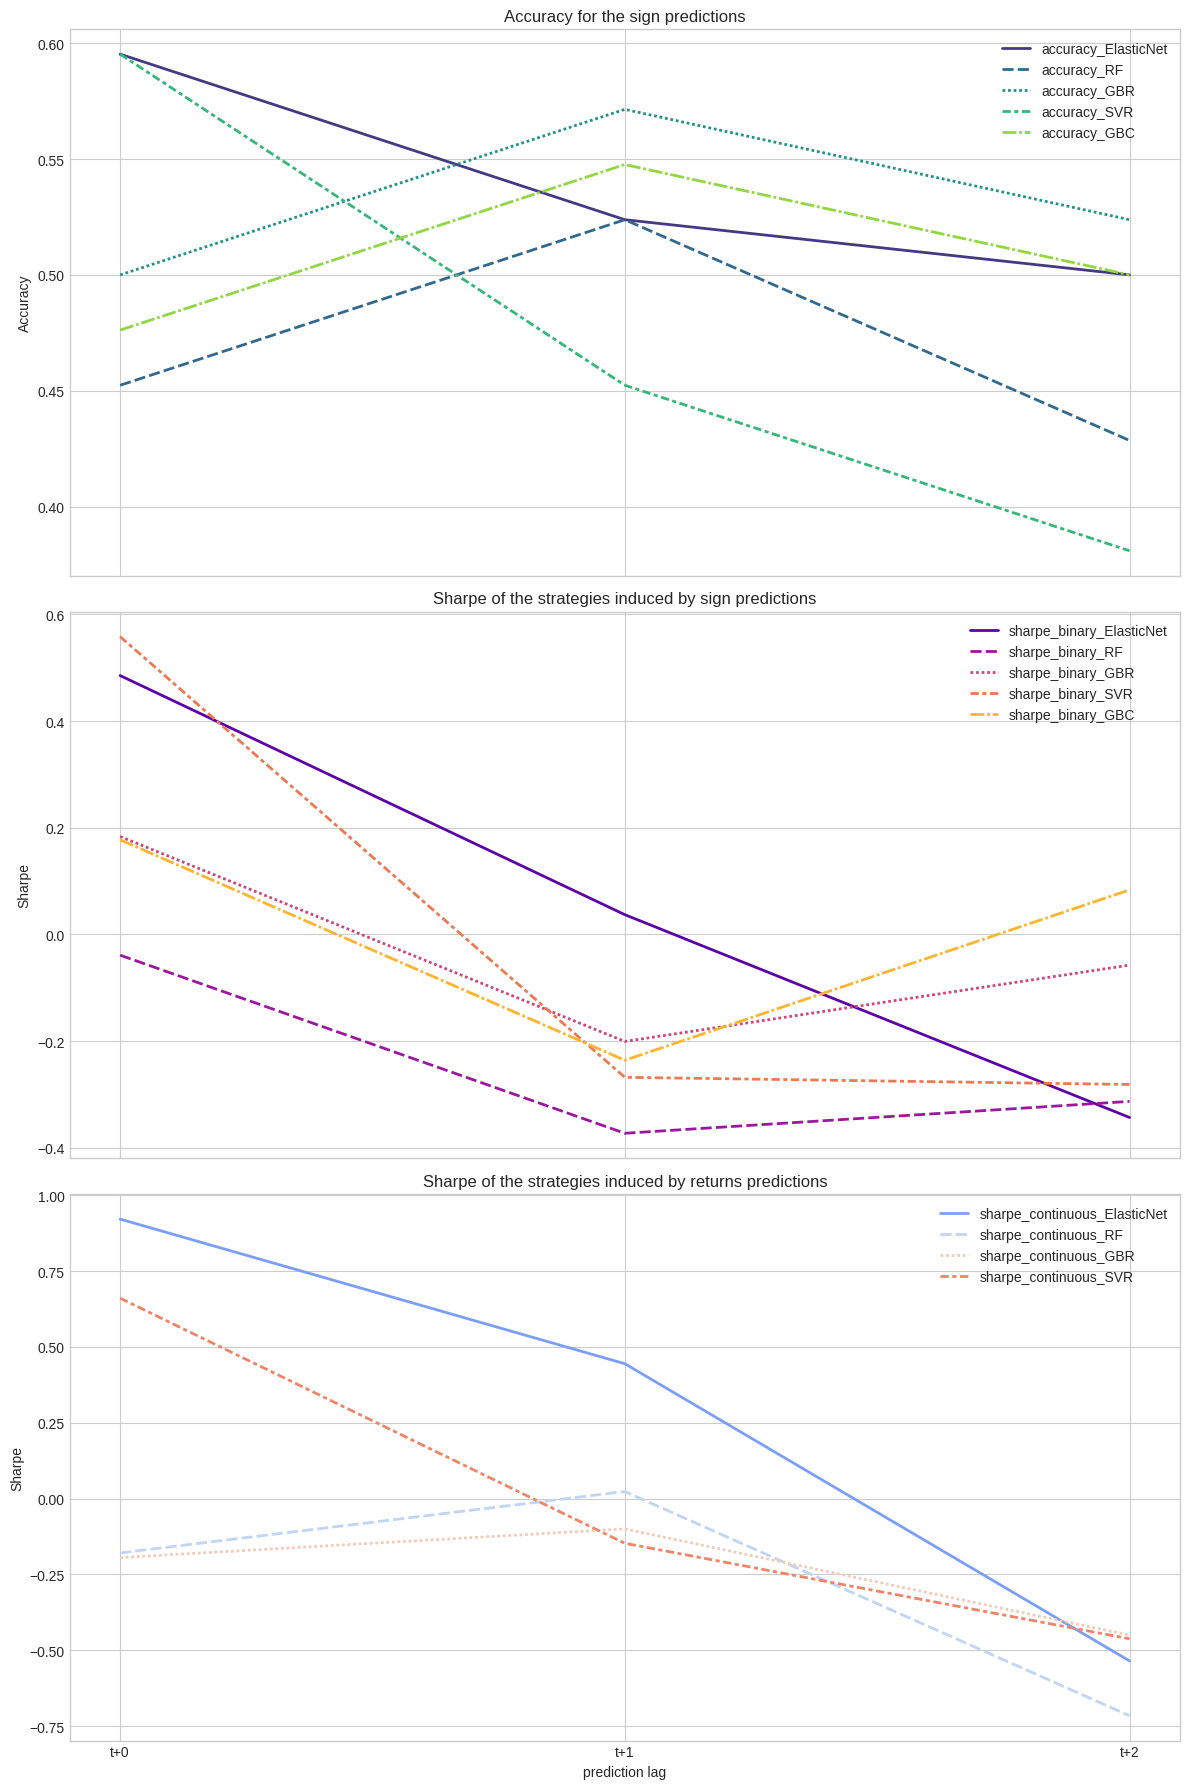

In [14]:
# This cells will plot the evolution of the accuracy (only for the sign prediction)
# and the sharpe induced by each NLP/Model predictions

accuracy_columns = [col for col in merged_df.columns if col.startswith("accuracy")]
sharpe_columns = [col for col in merged_df.columns if col.startswith("sharpe")]
sharpe_cont_columns = [col for col in merged_df_cont.columns if col.startswith("sharpe")]

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# Plotting Accuracy columns
sns.lineplot(ax=axes[0], data=merged_df[accuracy_columns], palette="viridis", linewidth=2)
axes[0].set_title('Accuracy for the sign predictions')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('prediction lag')

# Plotting Sharpe columns
sns.lineplot(ax=axes[1], data=merged_df[sharpe_columns], palette="plasma", linewidth=2)
axes[1].set_title('Sharpe of the strategies induced by sign predictions')
axes[1].set_ylabel('Sharpe')
axes[1].set_xlabel('prediction lag')

# Plotting Sharpe continuous columns
sns.lineplot(ax=axes[2], data=merged_df_cont[sharpe_cont_columns], palette="coolwarm", linewidth=2)
axes[2].set_title('Sharpe of the strategies induced by returns predictions')
axes[2].set_ylabel('Sharpe')
axes[2].set_xlabel('prediction lag')

# Set common xlabel

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


Our implementation has 2 fundamental problems. Firstly, we split our dataset because we want to avoid forward information bias when computing the Pnl on the very dataset used to train the model. However, by spliting our already scarce dataset, we have on one hand less points to train the model, and most importantly on the other hand very few data points (about 30) to compute the Pnl series. Thus, our Sharpe ratios vary highly from one simulation to the other, and it is complicated to be confident about a particular strategy over another one.

The second problem we face is that our strategy only trades about 8 times per year, and only on daily returns which seems quite limited.

We analyse the following general trends: after running the simulations a few times, we see that t+0 returns tend to be more influenced by our NLP analysis, which makes sense as markets price in new information very rapidly. Overall, the Sharpe ratio tend to decrease with the lag on the prediction. The best Sharpe ratios obtained are thus for t+1 predictions, and generally come from the return predicting algorithms. Best ones are in the region of 0.5 and for the ElasticNet.

We will try to correct our first problem in the next cells. As for the second one, it cannot be alleviated by the very nature of our strategy. It could nonetheless be combined with a mean reverting strategy: for instance, if we predict a positive t+1 return, we could also add a short position the following day and vice versa.

We here try to improve the robustness of our Sharpe estimator. We compute the 5-fold cross validation for the ElasticNet model on the continuous strategy to improve the precision of the convergence of our estimator.

In [15]:
from sklearn.model_selection import KFold
skf = KFold(n_splits=5)
returns=compute_lagged_return(vix_data,1)

est = Pipeline([
    ("tfidf", TfidfVectorizer(
        vocabulary=None,
        ngram_range=(1, 3),
        max_features=300,
        stop_words="english",
        token_pattern=r"\b[a-zA-Z]{3,}\b",
    )),
    ("reg",  ElasticNet(alpha=0.008))
])






#returns=returns[(returns['Close'] < -0.05) | (returns['Close'] > 0.05)]
y=returns["Close"].dropna()
y_index=y.index
statements_concerned=statements.loc[statements.index.isin(y_index)]


X=statements_concerned['text']
y=y.loc[X.index]




result=[]
vocab_coef = pd.DataFrame()
for train_index, test_index in skf.split(X, y):
  X_train, X_test, y_train, y_test = X.iloc[train_index],X.iloc[test_index],y.iloc[train_index],y.iloc[test_index]
  est.fit(X_train, y_train)
  vocab_ = pd.Series(est.named_steps["tfidf"].vocabulary_).sort_values().index
  interpret_coef = pd.DataFrame(np.transpose(est.named_steps["reg"].coef_), index=vocab_)
  vocab_coef = pd.concat([vocab_coef, interpret_coef])

  y_pred = est.predict(X_test)
  results=pd.DataFrame(y_test)
  results['pred']=y_pred
  result.append(results)


vocab_coef.groupby(vocab_coef.index).sum()/5

lag=1
final_results=pd.concat(result)
data=pd.merge(final_results,vix_data['Close'],left_index=True,right_index=True)
data=pd.merge(data,vix_data['Close'].shift(-lag),left_index=True,right_index=True)

data.columns=['Sign at t+'f'{lag}','Pred Sign at t+'+f'{lag}','Price at t','Price at t+'+f'{lag}']
data['return at date t+'+f'{lag}']=(data['Price at t+'+f'{lag}']-data['Price at t'])/data['Price at t']

data['P&L']=data['Pred Sign at t+'+f'{lag}']*data['return at date t+'+f'{lag}']

df_sharpe=pd.DataFrame(index=y.index)#index=range(5000)
#df_sharpe['P&L']=data.reset_index(drop=True)['P&L']
df_sharpe['P&L']=data['P&L']
df_sharpe['P&L']=df_sharpe['P&L'].fillna(0)
sharpe=np.sqrt(8/lag)*df_sharpe['P&L'].mean()/(df_sharpe['P&L'].std()*np.sqrt(2))



-0.9937415835315813


<AxesSubplot:title={'center':'Pnl Series'}>

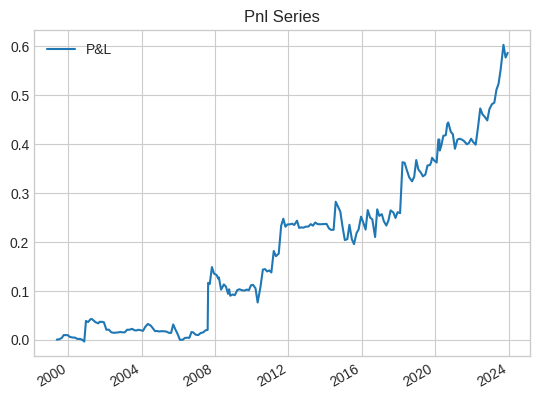

In [36]:
print(sharpe)
data[['P&L']].cumsum().plot(title = "Pnl Series")

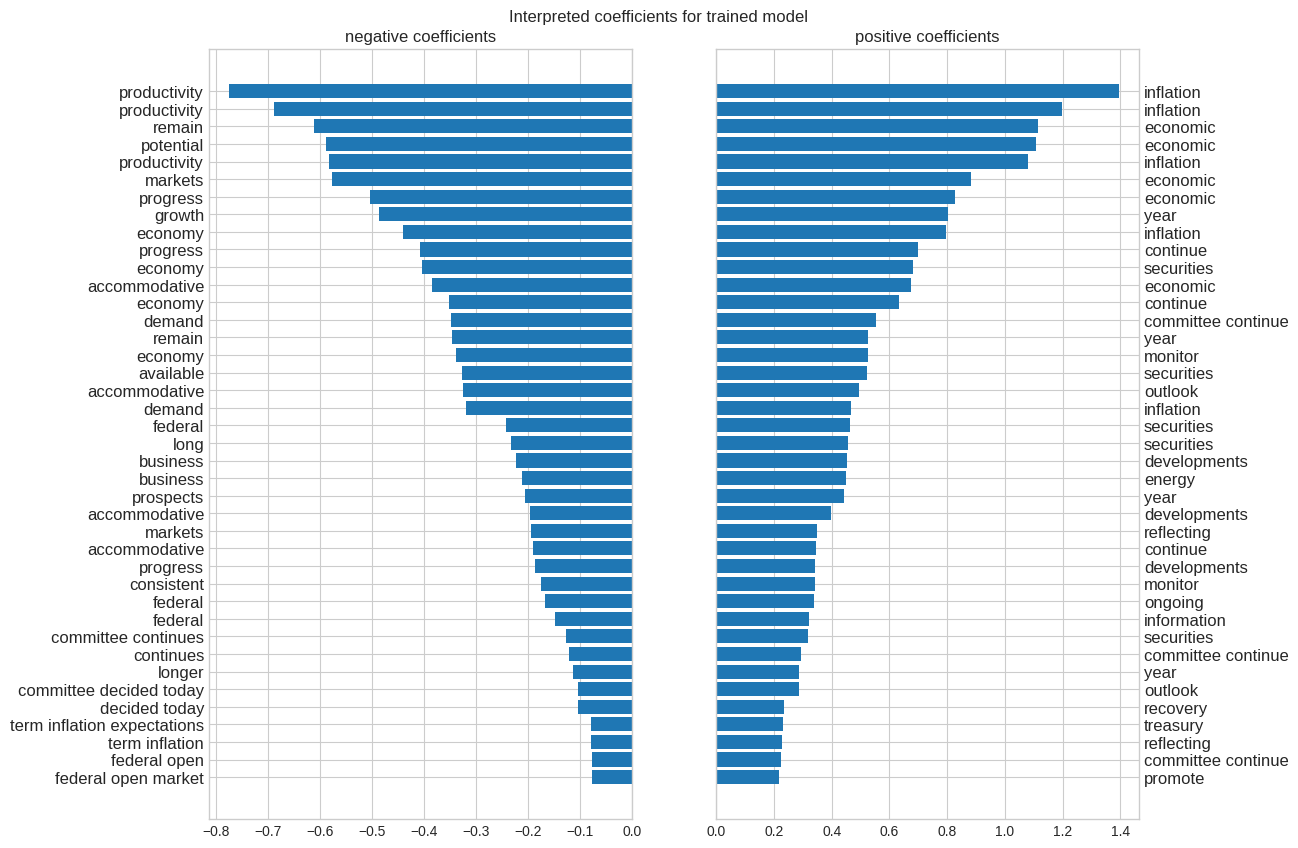

In [17]:
coefs_plot(vocab_coef, title="Interpreted coefficients for trained model")

In what we consider to be the final version of the strategy, we obtain a Sharpe of 0.32, which is not really worthy of excitement. We shall try to improve that result in the following section. We also plot the most impactful words on average from the statements.

# Attempt of improvement through a rate-based strategy

To complement this strategy, we go back to the essence of the VIX index. We know that the VIX usually reacts positively (ie it decreases) to increases in Fed fund rates as it brings down uncertainty and danger. We now study the relation between rate changes (as a result of FOMC meetings) and VIX returns.

Ideally, we would compare market expectations of rate changes versus the actual changes, as this would probably be the best indication of immediate upcoming change in the market. This data was unfortunately not found (we tried to reverse engineer it through interest rate swaps, but to no avail). The next best tool is simply the real change changes, using the dataset from skfin. We differanciate certain events from regular meetings just as in the lectures, in the 'other' category.

In [18]:
fomc_change_up, fomc_change_dw = load_fomc_change_date()

other = {
    "other_dt_change": ["2003-01-09", "2008-03-16", "2011-06-22"],
    "statements_dt_change_other": ["2007-08-16"],
    "qe1": ["2008-11-25", "2008-12-01", "2008-12-16", "2009-03-18"],
    "qe2": ["2010-11-03"],
    "twist": ["2011-09-21", "2012-06-20"],
    "qe3": ["2012-09-13", "2012-12-12", "2013-12-13"],
    "corona": ["2020-03-20"],
}

dates = {
    "up": fomc_change_up,
    "dw": fomc_change_dw,
    "other": [pd.Timestamp(d) for c in other.values() for d in c],
}
dates["no change"] = statements.index.difference([d for c in dates.values() for d in c])

In [19]:
df = pd.DataFrame()
for change in dates:
  change_list = []
  for date in dates[change]:
    if date in vix_returns.index:
      change_list.append(vix_returns.loc[date]['Close'])
  change_df = pd.DataFrame(change_list, index = [a for a in dates[change] if a in vix_returns.index], columns = [change])
  df = pd.concat([df, change_df])

print("mean")
print(df.mean())

print("std")
print(df.std())

mean
up          -0.031388
dw           0.001123
other       -0.010878
no change   -0.017992
dtype: float64
std
up           0.056905
dw           0.112059
other        0.095722
no change    0.082222
dtype: float64


In [20]:
df = pd.DataFrame()
for change in dates:
  change_list = []
  for date in dates[change]:
    if date in vix_returns.shift(-1).index:
      change_list.append(vix_returns.shift(-1).loc[date]['Close'])
  change_df = pd.DataFrame(change_list,
                           index = [a for a in dates[change] if a in vix_returns.shift(-1).index],
                           columns = [change])
  df = pd.concat([df, change_df])

print("mean")
print(df.mean())

print("std")
print(df.std())

mean
up           0.010430
dw          -0.004667
other        0.008617
no change    0.005740
dtype: float64
std
up           0.082711
dw           0.085604
other        0.077007
no change    0.086795
dtype: float64


In [21]:
print(vix_returns.mean())

Close    0.002405
dtype: float64


These two cells serve as proof that on average, the VIX reacts differently to rises in rates compared to no change or a decrease in rates. First cell looks at returns the day of the meeting and the second one at returns the following day. As we expected, the VIX on average goes down when a rate hike occurs and ever so slightly goes up for rate cutes. Neutral dates go down on average, which is compatible with our first part analysis.

In spite of that, we cannot really infer any trends from returns on t+1 dates, which is not ideal in our context, but we continue nonetheless.

<AxesSubplot:>

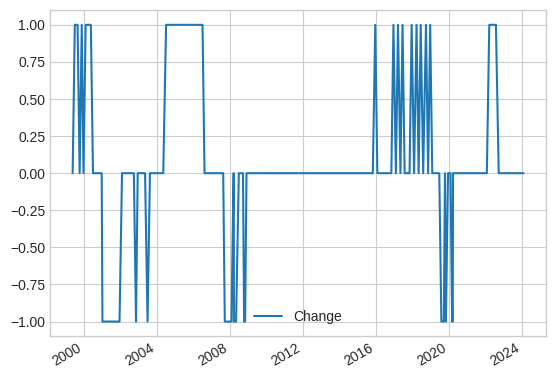

In [22]:
rate_changes = pd.DataFrame(columns = ['Change'])
for change in dates:
  signe = 0
  if change == 'up':
    signe = 1
  elif change == 'dw':
    signe = -1
  for date in dates[change]:
    rate_changes.loc[date] = signe
rate_changes = rate_changes.sort_index()
rate_changes.plot()

In [23]:
def rates_strat(pred, lag = 1):
  common_index = vix_returns.shift(-lag).dropna().index.intersection(pred.index)
  df = (vix_returns.shift(-lag).dropna().loc[common_index])
  df['pred'] = pred.loc[common_index]
  df['Pnl'] = df['Close'] * df['pred']
  pnl = df['Pnl']
  sharpe = np.sqrt(8)/np.sqrt(2) * pnl.mean()/pnl.std()
  print("Sharpe : " + str(np.round(sharpe, 4)))
  return pnl.cumsum().plot(title = 'Pnl series')

Sharpe : 0.0937


<AxesSubplot:title={'center':'Pnl series'}>

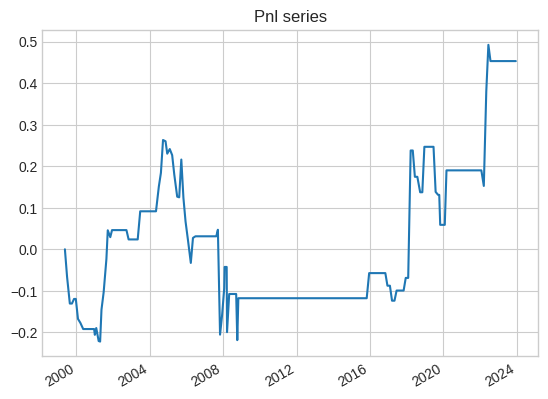

In [24]:
rates_strat(rate_changes)

The cell above considers a very simple strategy, being long the VIX on the day after a rate hike and short after a rate cut, in accordance to figure above. As expected, this is not great as it's extremely simple and t+1 returns are not so differently affected by rate decison by the FOMC. We try something more sophisticated.

In [25]:
new_idx = vix_returns.index.intersection(rate_changes.index)
new_idx2 = vix_returns.index.intersection(rate_changes.index+pd.tseries.offsets.BDay(1))
y = vix_returns.shift(-1).loc[new_idx]
X = rate_changes.loc[new_idx]

X.drop(X.index[-1], inplace=True)
y.drop(y.index[-1], inplace=True)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [26]:
pipe = Pipeline([('reg', ElasticNet(max_iter=5000))])#('scaler', StandardScaler()),
parameters = {'reg__alpha': np.linspace(1e-7, 1e3, 100)} # defining parameter space
clf = GridSearchCV(pipe, parameters)
clf.fit(X, y)
print('Returned hyperparameter: {}'.format(clf.best_params_))

Returned hyperparameter: {'reg__alpha': 10.1010102}


We first try to regress the returns on the rate decisions, modelled here by +1 for a hike, -1 for a cut, and 0 ortherwise. This doesn't give an interesting result. We then try a light gradient boosting machine classifier.

<AxesSubplot:>

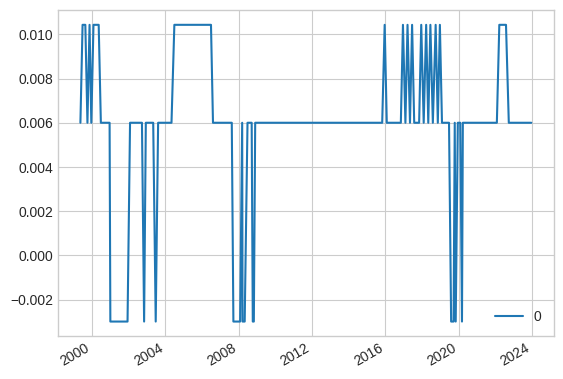

In [27]:
from lightgbm import LGBMRegressor
pipe2 = Pipeline([('reg', LGBMRegressor(n_estimators=1000))])#RandomForestRegressor(n_estimators=1000)
pipe2.fit(X, y)

res = pd.DataFrame(pipe2.predict(X))
res.index = X.index
res.plot()

Sharpe : 0.1591


<AxesSubplot:title={'center':'Pnl series'}>

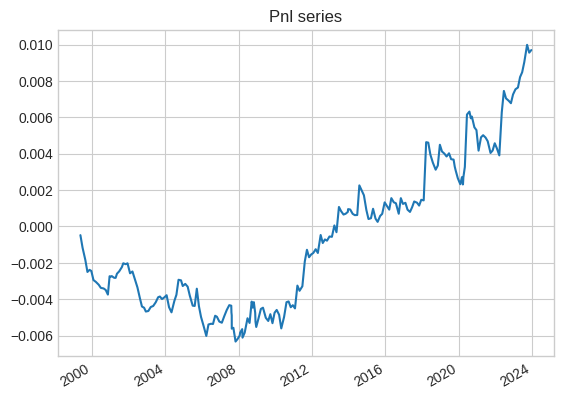

In [28]:
rates_strat(res)

The results obtained are slightly improved on the first ones, but still far away from anything tradable. Similarly to the ensemble paradigm, we try to combine the predictions from the NLP strategy and the rate strategy.

In [29]:
def final_strat(strat1, strat2):
  common_idx = strat1.index.union(strat2.index)
  scaler = StandardScaler()
  strat_1 = pd.DataFrame(scaler.fit_transform(strat1), columns=strat1.columns)
  strat_2 = pd.DataFrame(scaler.fit_transform(strat2), columns=strat2.columns)

  strat_1 = scaler.fit_transform(strat1)
  strat_2 = scaler.fit_transform(strat2)

  strat_1 = pd.DataFrame(strat_1, index=strat1.index, columns=strat1.columns)
  strat_2 = pd.DataFrame(strat_2, index=strat2.index, columns=strat2.columns)


  df = pd.DataFrame(index = common_idx)
  df = pd.concat([df, strat_1], axis = 1)
  df = pd.concat([df, strat_2])
  df = df.groupby(df.index).sum()
  df = df.sum(axis = 1)/2
  return df

In [30]:
final_strat(res, data[['Pred Sign at t+1']])

1999-05-18   -0.320491
1999-06-30    0.273954
1999-08-24    0.163437
1999-10-05   -0.489006
1999-11-16    0.212593
                ...   
2023-06-14    0.497085
2023-07-26    0.624707
2023-09-20    0.626893
2023-11-01    0.759814
2023-12-13    0.887372
Length: 216, dtype: float64

Sharpe : 0.2245


<AxesSubplot:title={'center':'Pnl series'}>

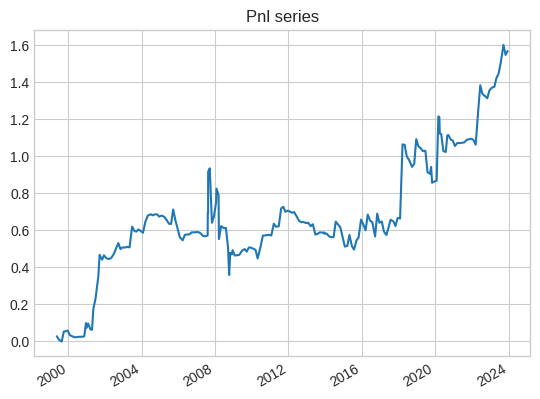

In [31]:
rates_strat(final_strat(res, data[['Pred Sign at t+1']]))

When averaging the normalised predictions from the 2 methods, it simply averages the Sharpes of the individual methods, so we get no improvement from there either. A final try could have been the alpha residual method. If we have a good strategy (ie with an interesting Sharpe) and a strategy with Sharpe close to 0, which generally indicates a risk-bearing strategy that are well correlated (which would be the case here as there must be correlation between the wording of the statements and the ddecision taken by the board), one can regress the strong strategy on the risk-bearing strategy to obtain a new strategy that should have reduced risk. We will not implement this as this would only make sense in a richer data environment but it could be a way to prolong these 2 strategies.

# Conclusion

To sum up, we wanted to study the relation between the VIX index and the scheduled statements released by the Federal Open Market Committee stating their decision concerning Fed fund rates. As often simultaneously interpreted as the index of both fear and uncertainty, we gathered that market participants would likely change their market views quite significantly around these meetings. The VIX is mainly traded through futures contracts and S&P options. As such, it's a decently liquid market and one would not expect to cross very wide spreads at conventional trading hours. We tried first a TFIDF method on the statements corpus to try to predict VIX returns on days around the meetings. Through cross-validation, we improved the robustness of the results and obtained a Sharpe ratio of 0.32. This signals that most of the movement and thus of the alpha took place intraday directly after the release of the statement. This is not negligible but an improved strategy would need intraday data, and even maybe investing all around the release date hoping for U-shaped returns. Furthermore, our strategy was quite passive as we only invested around 8 times per year. It could as such be used as a hedging tool within a larger strategy, to protect against volatile moves around FOMC meetings for example.


Nonetheless, our study verified many properties about the VIX index and its behaviour around marcoeconomic anouncements: it's quite mean-reverting, it usually decreases on FOMC meetings dates, especially for hike rates. Also, its returns are quite U-shaped around statements: implied market vol is quite high before the statement, quickly decreases and comes back up again.


We then elected to try to improve our initial strategy with a simple method on the actual rate decisions from the statents as the VIX also reacts differently according to the decision. We unfortunately suffered from very similar problems: incapacity to obtain the necessary data to fully expand on our ideas. We nonetheless tried to combine both strategies, more or less in vain.


Finally, we include a small appendice detailing how one could adapt our strategy to the VVIX index, which holds similar properties to the VIX. It would be a less crowded trade but more difficult to replicate in practice as it's not an easily traded asset.

# Appendice : study of the VVIX index

In the first part, we observed on one of the graphs that the std of VIX returns increased around FOMC meetings. This spiked our curiosity as to what our first study would mean for the VVIX index, which is often referred to as 'the VIX of the VIX', ie the expected volatility of the VIX futures contract. Similarly to the VIX index, there are futures on that index, even though it must be a less liquid market, as not many participants are interested in trading it (it is a useful indicator of expected volatility regime just like the VIX). Furthermore, as it was introduced quite recently by the CBOE, there doesn't seem to be any major literature on the subject yet. This is not the focus of our work, simply an additional resource where we apply the exact same NLP methodology.

In [32]:
vvix_ticker = "^VVIX"

start_date = "1999-01-01"
end_date = "2024-02-01"

vvix_data = yf.download(vvix_ticker, start=start_date, end=end_date)

vvix_returns=pd.DataFrame(vvix_data['Close'].pct_change()[1:])

[*********************100%***********************]  1 of 1 completed


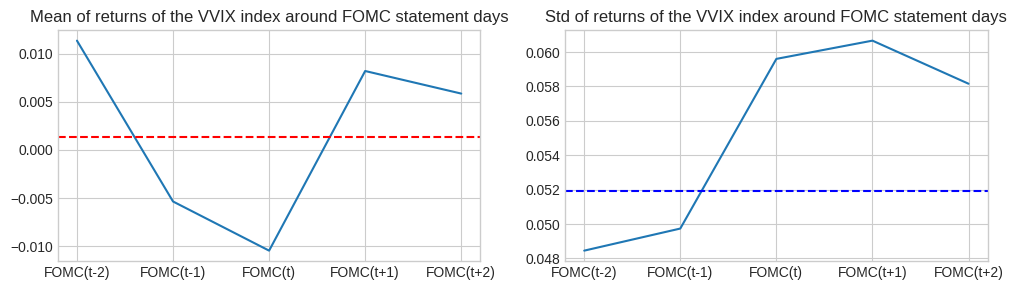

In [33]:
range_ = 2
lags = [i for i in range(-range_, range_+1)]
means = []
stds = []
for lag in lags:
  laged_index = statements.index + pd.tseries.offsets.BDay(lag)
  vvix_laged = vvix_returns.loc[laged_index.intersection(vvix_returns.index)]
  mean = vvix_laged.mean()['Close']
  std = vvix_laged.std()['Close']
  stds.append(std)
  means.append(mean)


stats_vvix_lag = pd.DataFrame({'means': means, 'stds': stds})
stats_vvix_lag.index = lags

fig, axs = plt.subplots(1, 2, figsize=(12, 3))

stats_vvix_lag['means'].plot(ax=axs[0])
axs[0].axhline(y=vvix_returns.mean()['Close'], color='r', linestyle='--',
               label=f'Horizontal Line at {np.round(vvix_returns.mean()["Close"], 5)}')
axs[0].set_xticks(lags)
axs[0].set_xticklabels(["FOMC(t-2)", "FOMC(t-1)", "FOMC(t)", "FOMC(t+1)", "FOMC(t+2)"])
axs[0].set_title('Mean of returns of the VVIX index around FOMC statement days')

stats_vvix_lag['stds'].plot(ax=axs[1])
axs[1].axhline(y=vvix_returns.std()['Close'], color='b', linestyle='--',
               label=f'Horizontal Line at {np.round(vvix_returns.std()["Close"], 5)}')
axs[1].set_xticks(lags)
axs[1].set_xticklabels(["FOMC(t-2)", "FOMC(t-1)", "FOMC(t)", "FOMC(t+1)", "FOMC(t+2)"])
axs[1].set_title('Std of returns of the VVIX index around FOMC statement days')

plt.show()

We seem to achieve very similar result to the VIX index. It's not that surprising as the VIX and VVIX are strongly correlated.

In [34]:
# We do it for each lag in [1,30]
models=['ElasticNet','RF','GBR','SVR']
index=['t+'f'{i}' for i in range(3)]
dfs_cont=[]
for model in models:
  data_continuous=[]
  for i in range(3):
    ret_fomc=compute_lagged_return(vvix_data,i)
    results=run_model_continuous(statements,ret_fomc,model)
    df,sharpe=compute_strategy(results,vvix_data,i)
    data_continuous.append(sharpe)
  final_continuous_result=pd.DataFrame(data_continuous,columns=['sharpe_continuous_'+model],index=index)
  dfs_cont.append(final_continuous_result)

merged_df_cont = reduce(lambda left, right: pd.merge(left,right,left_index=True,right_index=True), dfs_cont)
merged_df_cont.head()

,sharpe_continuous_ElasticNet,sharpe_continuous_RF,sharpe_continuous_GBR,sharpe_continuous_SVR
t+0,0.137628,-0.332525,-0.085970,0.402197
t+1,-0.178463,-0.336747,-0.319803,0.015510
t+2,-0.408008,-0.913109,-0.569994,-0.993742


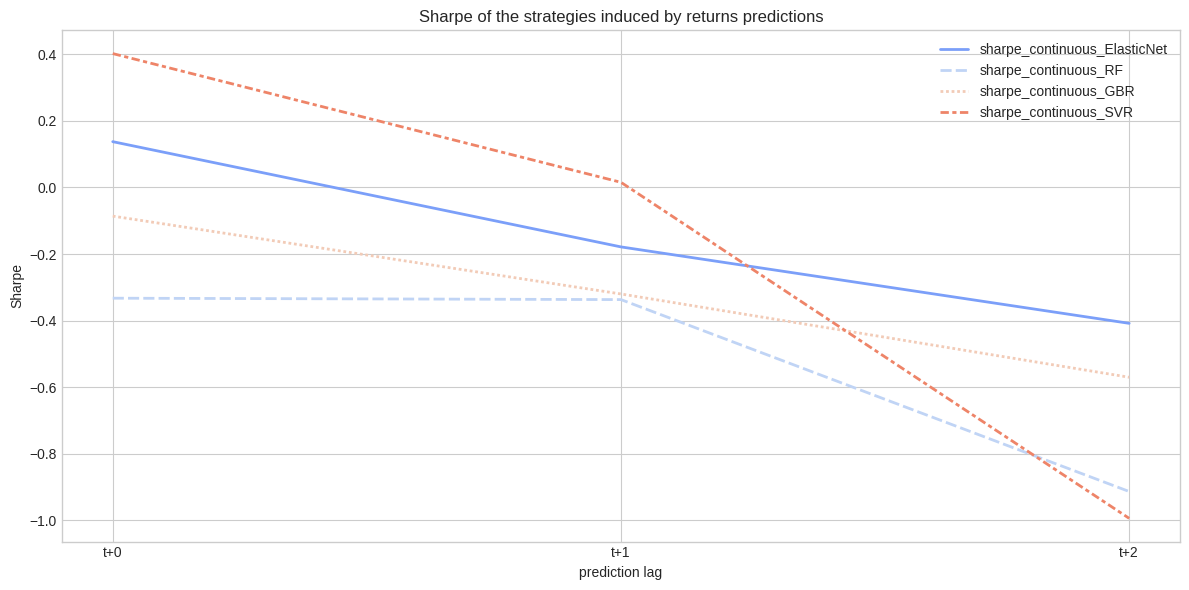

In [35]:
# This cells will plot the evolution of the accuracy (only for the sign prediction)
# and the sharpe induced by each NLP/Model predictions

sharpe_cont_columns = [col for col in merged_df_cont.columns if col.startswith("sharpe")]

# Create subplots
fig, ax = plt.subplots(figsize=(12, 6))


# Plotting Sharpe continuous columns
sns.lineplot(ax=ax, data=merged_df_cont[sharpe_cont_columns], palette="coolwarm", linewidth=2)
ax.set_title('Sharpe of the strategies induced by returns predictions')
ax.set_ylabel('Sharpe')
ax.set_xlabel('prediction lag')

# Set common xlabel

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


There appears to be stronger predictability for the VVIX, even though it's in the opposite way we wanted, especially for t+2 returns. This is likely due to the mean-reverting properties of the VVIX, similarly to the VIX, as well as U-shaped returns around FOMC announcements. Shorting one of these strategies might be of interest. It seems that strategies involving the VVIX/VIX ratio exist (Trading ‘Vol of Vol’ and the VVIX/VIX Ratio, Sage Anderson, 2021), so one might study the properties of that ratio to combine both assets.